In [1]:
!pip install torch torchvision
!pip install transformers
!pip install pandas
!pip install numpy

     |████████████████████████████████| 4.0 MB 16.1 MB/s 
     |████████████████████████████████| 596 kB 41.1 MB/s 
     |████████████████████████████████| 77 kB 8.0 MB/s 
     |████████████████████████████████| 6.6 MB 46.8 MB/s 
     |████████████████████████████████| 895 kB 38.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
!gsutil cp gs://boolq/train.jsonl .
!gsutil cp gs://boolq/dev.jsonl .

Copying gs://boolq/train.jsonl...
\ [1 files][  6.2 MiB/  6.2 MiB]                                                
Operation completed over 1 objects/6.2 MiB.                                      
Copying gs://boolq/dev.jsonl...
- [1 files][  2.1 MiB/  2.1 MiB]                                                
Operation completed over 1 objects/2.1 MiB.                                      


In [3]:
import random
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW

In [4]:
torch.cuda.is_available()

True

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set seeds for reproducibility
random.seed(26)
np.random.seed(26)
torch.manual_seed(26)

tokenizer = AutoTokenizer.from_pretrained("roberta-large") 

model = AutoModelForSequenceClassification.from_pretrained("roberta-large")
model.to(device)

learning_rate = 1e-5
optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8)

Downloading:   0%|          | 0.00/482 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifie

In [6]:
def encode_data(tokenizer, questions, passages, max_length):
    """Encode the question/passage pairs into features than can be fed to the model."""
    input_ids = []
    attention_masks = []

    for question, passage in zip(questions, passages):
        encoded_data = tokenizer.encode_plus(question, passage, max_length=max_length, pad_to_max_length=True, truncation_strategy="longest_first")
        encoded_pair = encoded_data["input_ids"]
        attention_mask = encoded_data["attention_mask"]

        input_ids.append(encoded_pair)
        attention_masks.append(attention_mask)

    return np.array(input_ids), np.array(attention_masks)

# Loading data
train_data_df = pd.read_json("/content/train.jsonl", lines=True, orient='records')
dev_data_df = pd.read_json("/content/dev.jsonl", lines=True, orient="records")

passages_train = train_data_df.passage.values
questions_train = train_data_df.question.values
answers_train = train_data_df.answer.values.astype(int)

passages_dev = dev_data_df.passage.values
questions_dev = dev_data_df.question.values
answers_dev = dev_data_df.answer.values.astype(int)

# Encoding data
max_seq_length = 256
input_ids_train, attention_masks_train = encode_data(tokenizer, questions_train, passages_train, max_seq_length)
input_ids_dev, attention_masks_dev = encode_data(tokenizer, questions_dev, passages_dev, max_seq_length)

train_features = (input_ids_train, attention_masks_train, answers_train)
dev_features = (input_ids_dev, attention_masks_dev, answers_dev)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [7]:
batch_size = 8

train_features_tensors = [torch.tensor(feature, dtype=torch.long) for feature in train_features]
dev_features_tensors = [torch.tensor(feature, dtype=torch.long) for feature in dev_features]

train_dataset = TensorDataset(*train_features_tensors)
dev_dataset = TensorDataset(*dev_features_tensors)

train_sampler = RandomSampler(train_dataset)
dev_sampler = SequentialSampler(dev_dataset)

train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)
dev_dataloader = DataLoader(dev_dataset, sampler=dev_sampler, batch_size=batch_size)

In [8]:
epochs = 3
grad_acc_steps = 4
train_loss_values = []
dev_acc_values = []

for _ in tqdm(range(epochs), desc="Epoch"):
  epoch_train_loss = 0
  model.train()
  model.zero_grad()

  for step, batch in enumerate(train_dataloader):

      input_ids = batch[0].to(device)
      attention_masks = batch[1].to(device)
      labels = batch[2].to(device)     

      outputs = model(input_ids, token_type_ids=None, attention_mask=attention_masks, labels=labels)

      loss = outputs[0]
      loss = loss / grad_acc_steps
      epoch_train_loss += loss.item()

      loss.backward()
      
      if (step+1) % grad_acc_steps == 0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        model.zero_grad()

  epoch_train_loss = epoch_train_loss / len(train_dataloader)          
  train_loss_values.append(epoch_train_loss)

  epoch_dev_accuracy = 0
  model.eval()

  for batch in dev_dataloader:
    
    input_ids = batch[0].to(device)
    attention_masks = batch[1].to(device)
    labels = batch[2]
                
    with torch.no_grad():        
        outputs = model(input_ids, token_type_ids=None, attention_mask=attention_masks)
                    
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    
    predictions = np.argmax(logits, axis=1).flatten()
    labels = labels.numpy().flatten() 
    
    epoch_dev_accuracy += np.sum(predictions == labels) / len(labels)

  epoch_dev_accuracy = epoch_dev_accuracy / len(dev_dataloader)
  dev_acc_values.append(epoch_dev_accuracy)

Epoch: 100%|██████████| 3/3 [1:18:57<00:00, 1579.15s/it]


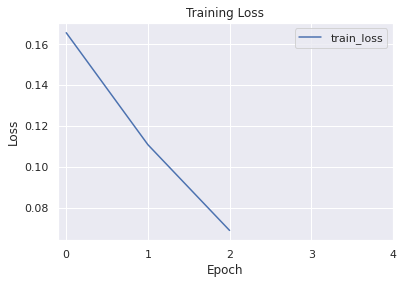

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

plt.plot(train_loss_values, label="train_loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.xticks(np.arange(0, 5))
plt.show()

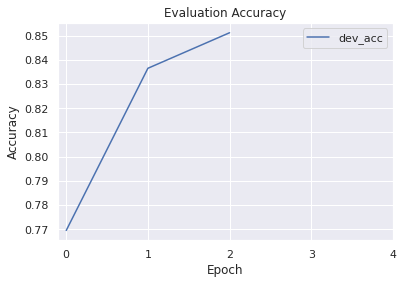

In [10]:
plt.plot(dev_acc_values, label="dev_acc")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Evaluation Accuracy")
plt.legend()
plt.xticks(np.arange(0, 5))
plt.show()

In [11]:
modelPath = './models/BooleanQAModel.pth'
torch.save(model.state_dict(), modelPath)

In [12]:
def predict(question, passage):
  sequence = tokenizer.encode_plus(question, passage, return_tensors="pt")['input_ids'].to(device)
  
  logits = model(sequence)[0]
  probabilities = torch.softmax(logits, dim=1).detach().cpu().tolist()[0]
  proba_yes = round(probabilities[1], 2)
  proba_no = round(probabilities[0], 2)

  print(f"Question: {question}, Yes: {proba_yes}, No: {proba_no}")
  
passage_superbowl = """Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the 'golden anniversary' with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as 'Super Bowl L'), so that the logo could prominently feature the Arabic numerals 50."""
passage_illuin = """Illuin designs and builds solutions tailored to your strategic needs using Artificial Intelligence and the new means of human interaction this technology enables."""

superbowl_questions = [
"Did the Denver Broncos win the Super Bowl 50?", 
"Did the Carolina Panthers win the Super Bowl 50?",
"Was the Super Bowl played at Levi's Stadium?", 
"Was the Super Bowl 50 played in Las Vegas?", 
"Was the Super Bowl 50 played in February?", 
"Was the Super Bowl 50 played in Feb?"
]

question_illuin = "Is Illuin the answer to your strategic needs?"

for s_question in superbowl_questions:
  predict(s_question, passage_superbowl)

predict(question_illuin, passage_illuin)

Question: Did the Denver Broncos win the Super Bowl 50?, Yes: 0.99, No: 0.01
Question: Did the Carolina Panthers win the Super Bowl 50?, Yes: 0.16, No: 0.84
Question: Was the Super Bowl played at Levi's Stadium?, Yes: 0.99, No: 0.01
Question: Was the Super Bowl 50 played in Las Vegas?, Yes: 0.01, No: 0.99
Question: Was the Super Bowl 50 played in February?, Yes: 0.98, No: 0.02
Question: Was the Super Bowl 50 played in Feb?, Yes: 0.97, No: 0.03
Question: Is Illuin the answer to your strategic needs?, Yes: 0.93, No: 0.07


In [17]:
import os
print(os.path.getsize('./models/BooleanQAModel.pth') / 1e+9)

1.421613229
